In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.company_data_pipeline import *
from src.ticker_data_pipeline import *
from src.model_pipeline import *
from src.model import Model
from __future__ import division

%matplotlib inline

In [2]:
# This function loads ticker data from the file, cleans it, and returns it as a pandas data frame
# It is slow.
# t_df = create_ticker_price_df()
# pickle_ticker_price_df(t_df)
ticker_df = unpickle_ticker_price_df()

# Takes the percent change and does some other cleaning
dif_df = diff_df(ticker_df)
# dif_df.plot(legend=False)

In [3]:
# Gather data, construct, and pickle model.

rebuild_model = False

if rebuild_model:
    company_df, tfidf, feature_names = get_company_description_df_tfidf_and_feature_names()
    m_ = Model(company_df, tfidf, feature_names, n_components=5)
    m_.fit(dif_df)
    pickle_model(m_)
m = unpickle_model()

In [4]:
def draw_importances_graph(names, importances, title, ax):
    n = len(names)
    #ax.figure()
    ax.set_title(title, fontdict={'fontsize': 10})
    ax.bar(range(n), importances,
           color="r", align="center")
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation='vertical')
    ax.set_xlim([-1, n])
    labels = ax.get_xticks()
    ax.tick_params(labelsize=20)

In [5]:
def graph_component(d):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
    f.subplots_adjust(bottom=0.01)

    draw_importances_graph(d['companies_con'],
                           d['importances_con'], 
                           "Company Importances Con",
                           ax1)

    draw_importances_graph(d['words_con'],
                           d['word_importances_con'], 
                           "Word Importances Con",
                           ax2)

    draw_importances_graph(d['companies_pro'],
                           d['importances_pro'], 
                           "Company Importances Pro",
                           ax3)

    draw_importances_graph(d['words_pro'],
                           d['word_importances_pro'], 
                           "Word Importances Pro",
                           ax4)


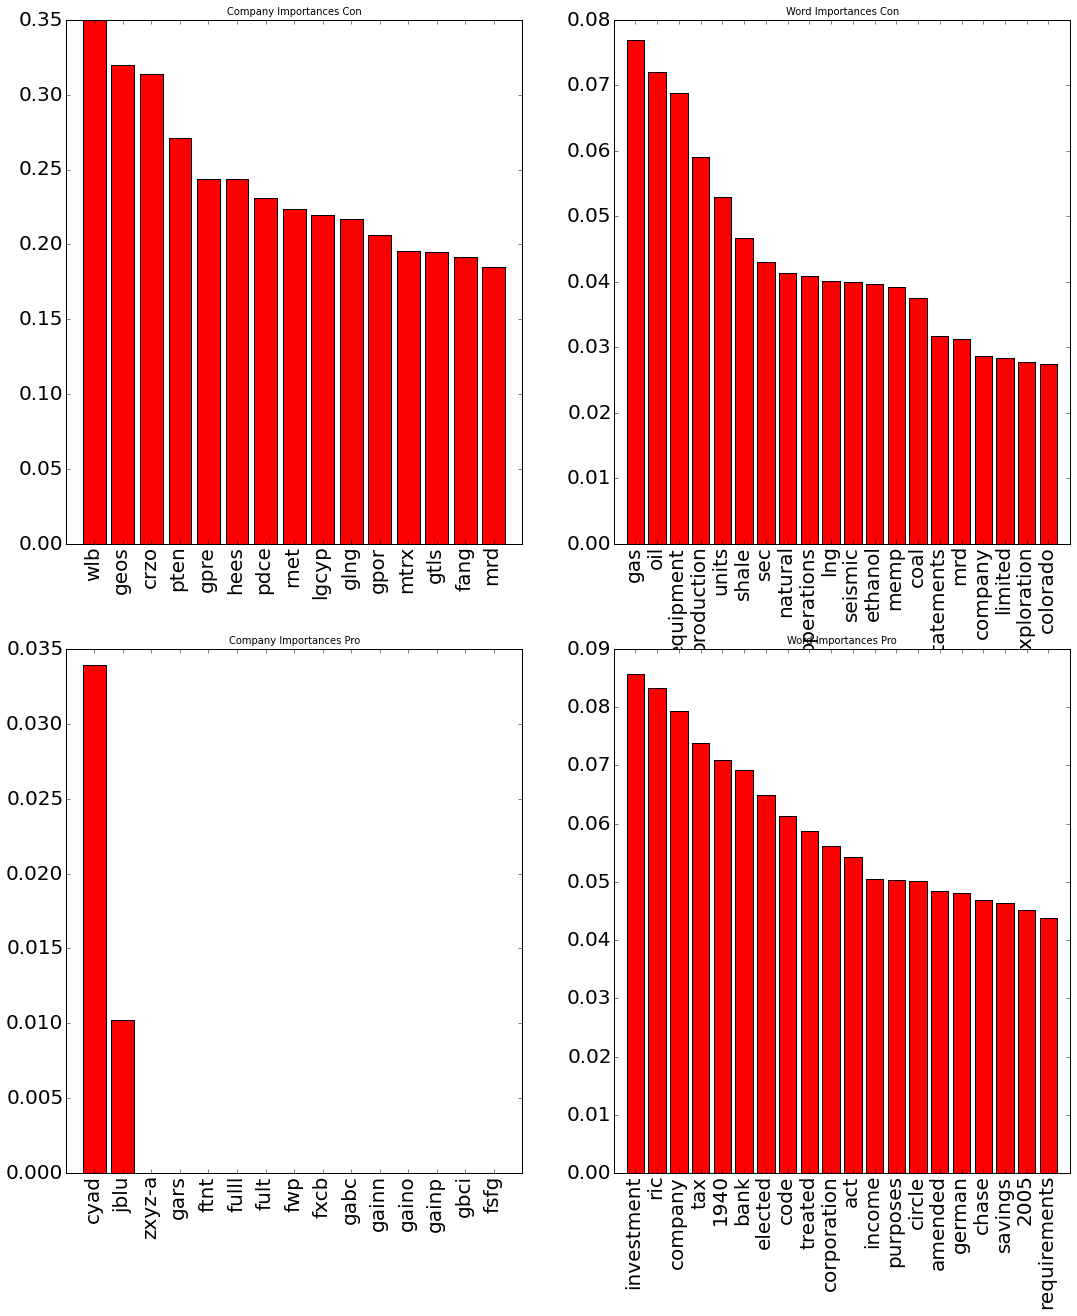

In [6]:
d = m.analyze_principle_component(3)
graph_component(d)

# one graph with all companies

In [7]:
# Components:
#     0 - Banking
#     1 - Biotech 
#     2 - International - China, Caymen Islands, Canada, Asia/Europe etc.  Does it 
#         reflect the value of the US Dollar?
#     3 - Oil, gas, coal
#     4 - Another Biotech and one Chinese social media company (fluke?)

/Users/Brian/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


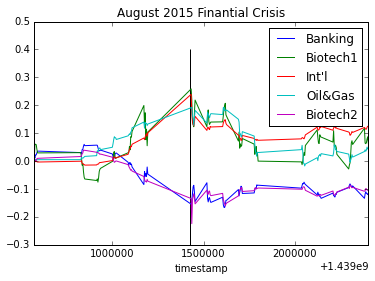

In [8]:
event_time = 1440423600
day = (24 * 60 * 60)

start = event_time - 10 * day
end = event_time + 14 * day

subset = ticker_df[(ticker_df.index >= start) & (ticker_df.index <= end)]
dif_from_start = diff_from_start(subset)
pc_df = m.transform(dif_from_start)
pc_df.columns = ['Banking', 'Biotech1', "Int'l", 'Oil&Gas', 'Biotech2']
ax = pc_df.plot(title='August 2015 Finantial Crisis')

# Vline is when the dow suddenly dropped 1000 points
ax.vlines(event_time, -0.3, 0.4)

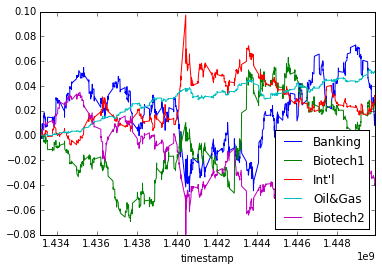

In [9]:
subset = ticker_df
dif_from_start = diff_from_start(subset)
pc_df = m.transform(dif_from_start)
pc_df.columns = ['Banking', 'Biotech1', "Int'l", 'Oil&Gas', 'Biotech2']
ax = pc_df.plot()

In [10]:
# We can clean up the data and get better results by finding a way to dedupe the list of
# companies.  Some are subsidiaries of the others and track very closely.  These are then 
# overrepresented in the data.

In [11]:
# We could try daily instead of hourly.  

In [12]:
# TODO: Weight the tfidf average by company importance.  

In [14]:
from collections import OrderedDict
import pandas as pd
from bokeh.charts import TimeSeries
from bokeh.plotting import show, output_file

# Here is some code to read in some stock data from the Yahoo Finance API
AAPL = pd.read_csv(
    "http://ichart.yahoo.com/table.csv?s=AAPL&a=0&b=1&c=2000&d=0&e=1&f=2010",
    parse_dates=['Date'])
MSFT = pd.read_csv(
    "http://ichart.yahoo.com/table.csv?s=MSFT&a=0&b=1&c=2000&d=0&e=1&f=2010",
    parse_dates=['Date'])
IBM = pd.read_csv(
    "http://ichart.yahoo.com/table.csv?s=IBM&a=0&b=1&c=2000&d=0&e=1&f=2010",
    parse_dates=['Date'])

xyvalues = OrderedDict(
    AAPL=AAPL['Adj Close'],
    Date=AAPL['Date'],
    MSFT=MSFT['Adj Close'],
    IBM=IBM['Adj Close'],
)

# any of the following commented are valid Bar inputs
#xyvalues = pd.DataFrame(xyvalues)
#lindex = xyvalues.pop('Date')
#lxyvalues = list(xyvalues.values())
#lxyvalues = np.array(xyvalues.values())

TOOLS="resize,pan,wheel_zoom,box_zoom,reset,previewsave"
output_file("stocks_timeseries.html")
ts = TimeSeries(xyvalues, 
                #index='Date', 
                title="timeseries, pd_input", tools=TOOLS,
                ylabel='Stock Prices', filename="stocks_timeseries.html")

# usage with iterable index
#ts = TimeSeries(lxyvalues, index=lindex, title="timeseries, pd_input",
#                ylabel='Stock Prices', filename="stocks_timeseries.html")

show(ts) # or ts.show()

/Users/Brian/anaconda/lib/python2.7/site-packages/bokeh/charts/chart.py:304: UserWarning: Chart property 'filename' was deprecated in 0.11             and will be removed in the future.
  and will be removed in the future.")


In [16]:
ts = TimeSeries(pc_df)
show(ts)